In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.patches import Circle
%matplotlib inline

In [3]:
df = pd.read_csv("../data/spots_g.csv", usecols=[2,4,5,7])
df.head(10)

,TRACK_ID,POSITION_X,POSITION_Y,POSITION_T
0,0,135.106,12.769,0
1,1,172.673,120.693,0
2,0,267.643,226.347,0
3,0,135.415,12.886,1
4,1,172.095,121.152,1
5,0,267.583,226.297,1
6,0,136.063,13.049,2
7,1,171.369,121.760,2
8,0,267.553,226.284,2
9,0,136.966,13.232,3


In [4]:
spots = df.values
print("Numer of spots:", len(spots)/3)

Numer of spots: 19960.666666666668


In [5]:
# separate the origin spots and arm spots
origin = []
arms = []

for spot in spots:
    # manually set the threshold to get all the origin spots
    if abs(spot[1] - 267) < 8 and abs(spot[2] - 226) < 8:
        origin.append(spot)
    else:
        arms.append(spot)
        
origin = [[spot[1], spot[2]] for spot in origin]
origin = np.array(origin)

# separate the top arm spots and bottom arm spots
top = np.zeros(origin.shape)
bottom = np.zeros(origin.shape)

# Have to manually match the TRACK_ID to either the top or bottom arm for each data set
for spot in arms:
    pos = int(spot[3])
    coord = [spot[1], spot[2]]    
    if spot[0] == 1:
        top[pos] = coord
    else:
        bottom[pos] = coord

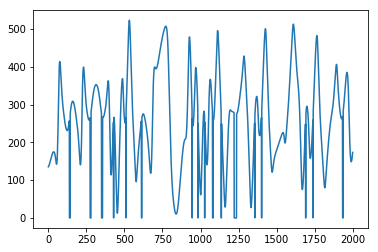

In [6]:
plt.plot(bottom[:2000,0])

In [7]:
# fill in the missing bottom arm spots
missing_indices = bottom == 0
# since the bottom arm spots are too close to the origin spots for ImageJ to differentiate, we assume they are the same
bottom[missing_indices] = origin[missing_indices]

In [9]:
FPS = 164
time = np.arange(0, len(origin)/FPS, 1/FPS)
print('Length of data:', len(origin))
print('Length of time:', len(time))

Length of data: 20000
Length of time: 20000


In [28]:
def coord2angle(x):
    slope = x[0] / x[1]
    base = np.arctan(slope)
    if x[0] >= 0 and x[1] >= 0:
        angle = base
    elif x[0] >= 0 and x[1] < 0:
        angle = base + np.pi
    elif x[0] < 0 and x[1] >= 0:
        angle = base
    else:
        angle = base - np.pi
    return angle

top_norm = top - origin
bottom_norm = bottom - top
theta1 = [coord2angle(coord) for coord in top_norm]
theta2 = [coord2angle(coord) for coord in bottom_norm]
theta1dot = np.gradient(theta1)
theta2dot = np.gradient(theta2)

a = 5000
b = 7000

init = theta1[a], theta1dot[a], theta2[a], theta2dot[a]

# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 0.02785, 0.0251
m1, m2 = 0.399, 0.276
# The gravitational acceleration (m.s-2).
g = 9.81

def deriv(y, t, L1, L2, m1, m2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot = z1
    z1dot = (m2*g*np.sin(theta2) - m2*s*(L1*z1**2*c + L2*z2**2) -
             (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
    theta2dot = z2
    z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
             m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
    return theta1dot, z1dot, theta2dot, z2dot

# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 5, 0.001
t = np.arange(0, tmax+dt, dt)
# Initial conditions.
div1 = 4
div2 = 2
y0 = init #[np.pi/div1, 0, 0, 0]

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))
# Unpack z and theta as a function of time
theta1p, theta1dotp, theta2p, theta2dotp  = y[:,0], y[:,1], y[:,2], y[:,3]

# Convert to Cartesian coordinates of the two bob positions.
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

Text(0,0.5,'theta2dot (rad/s)')

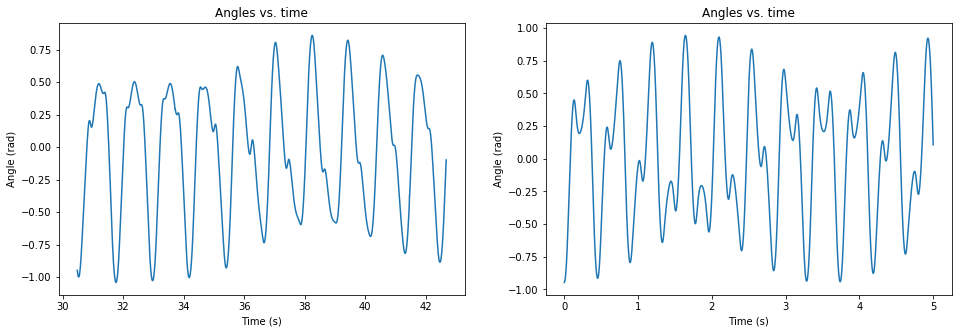

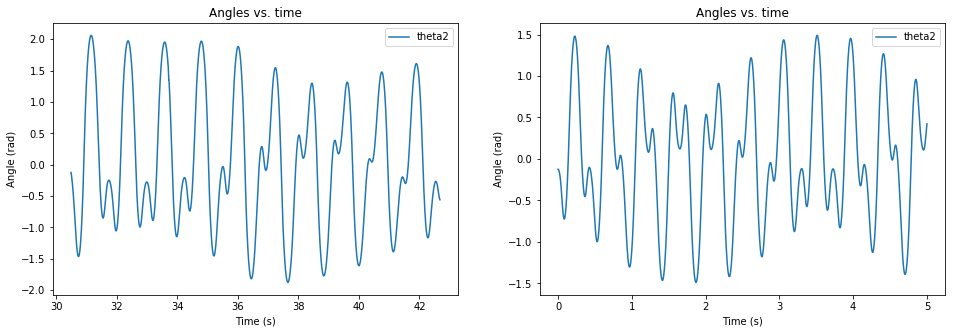

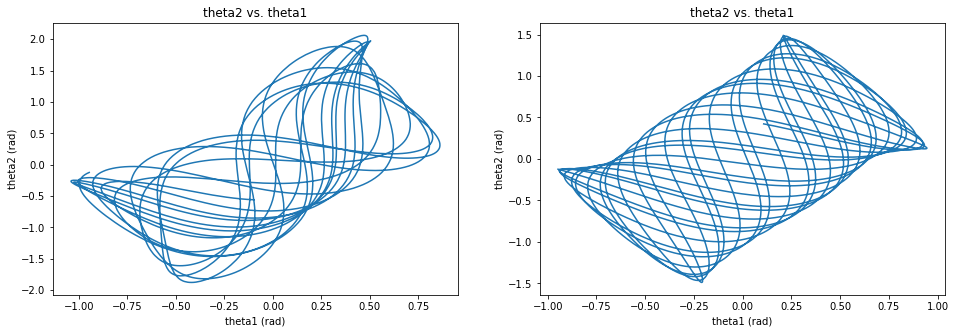

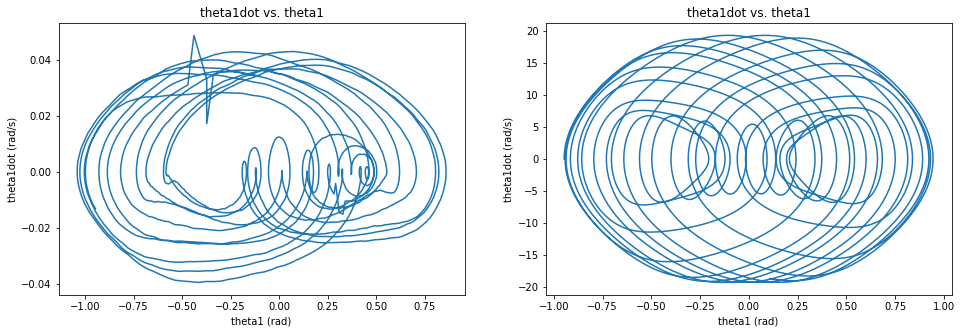

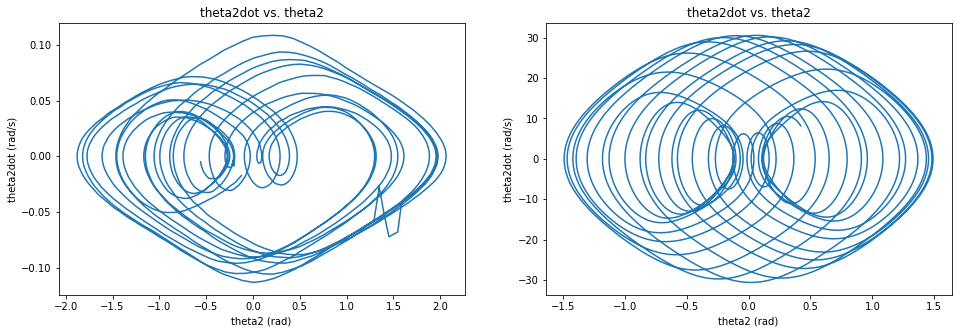

In [29]:
figsize = (16,5)

plt.figure(figsize=figsize)
plt.subplot(1, 2, 1)
plt.plot(time[a:b], theta1[a:b], label='theta1')
plt.title('Angles vs. time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')

plt.subplot(1, 2, 2)
plt.plot(t, theta1p, label='theta1')
plt.title('Angles vs. time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')


plt.figure(figsize=figsize)
plt.subplot(1, 2, 1)
plt.plot(time[a:b], theta2[a:b], label='theta2')
plt.title('Angles vs. time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, theta2p, label='theta2')
plt.title('Angles vs. time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()


plt.figure(figsize=figsize)
plt.subplot(1, 2, 1)
plt.plot(theta1[a:b], theta2[a:b])
plt.title('theta2 vs. theta1')
plt.xlabel('theta1 (rad)')
plt.ylabel('theta2 (rad)')

plt.subplot(1, 2, 2)
plt.plot(theta1p, theta2p)
plt.title('theta2 vs. theta1')
plt.xlabel('theta1 (rad)')
plt.ylabel('theta2 (rad)')


plt.figure(figsize=figsize)
plt.subplot(1, 2, 1)
plt.plot(theta1[a:b], theta1dot[a:b])
plt.title('theta1dot vs. theta1')
plt.xlabel('theta1 (rad)')
plt.ylabel('theta1dot (rad/s)')

plt.subplot(1, 2, 2)
plt.plot(theta1p, theta1dotp)
plt.title('theta1dot vs. theta1')
plt.xlabel('theta1 (rad)')
plt.ylabel('theta1dot (rad/s)')


plt.figure(figsize=figsize)
plt.subplot(1, 2, 1)
plt.plot(theta2[a:b], theta2dot[a:b])
plt.title('theta2dot vs. theta2')
plt.xlabel('theta2 (rad)')
plt.ylabel('theta2dot (rad/s)')

plt.subplot(1, 2, 2)
plt.plot(theta2p, theta2dotp)
plt.title('theta2dot vs. theta2')
plt.xlabel('theta2 (rad)')
plt.ylabel('theta2dot (rad/s)')

print("theta1  theta1dot  theta2  theta2dot")
print(np.round(init, 3))